In [32]:
import sklearn
print('The scikit-learn version is {}.'.format(sklearn.__version__))

The scikit-learn version is 0.21.3.


In [33]:
from sklearn.inspection import partial_dependence
from sklearn.inspection import plot_partial_dependence


In [34]:
import pandas as pd
from pandas.plotting import scatter_matrix

import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_validate
from sklearn.metrics import mean_squared_error, mean_absolute_error, confusion_matrix, r2_score, classification_report

import math

from rfpimp import *

from collections import defaultdict

In [35]:
file = "/Users/lszczyrba/Documents/Research/Projects/PR_Housing/Data/master_df_20200206.xlsx"
data = pd.read_excel(file)
df_master = pd.DataFrame(data).set_index('FIPS')

In [36]:
print(df_master.columns)

Index(['PropSFHA', 'AveDepth', 'PropDG', 'MaxDepth', 'AveLS', 'HurTrack',
       'PeakGust', 'MaxSusta', 'SpecCom', 'STRVI_1', 'SEVI_1', 'STR_SEVI_1',
       'SOVI_1', 'STRVI_2', 'SEVI_2', 'SOVI_2', 'CDC_T1', 'CDC_T2', 'CDC_T3',
       'CDC_T4', 'CDC_Tot', 'O_IND', 'R_IND', 'R_I_NO0', 'R_I_NOO',
       'R_I_NO0_NO', 'CAT_3Q', 'CAT_4Q', 'Ex_Q4_c', 'COUNT__Y', 'R_DES',
       'R_AFF', 'log_R_IND', 'log_R_I_NO0'],
      dtype='object')


In [37]:
df_master.describe()

,PropSFHA,AveDepth,PropDG,MaxDepth,AveLS,HurTrack,PeakGust,MaxSusta,SpecCom,STRVI_1,...,R_I_NOO,R_I_NO0_NO,CAT_3Q,CAT_4Q,Ex_Q4_c,COUNT__Y,R_DES,R_AFF,log_R_IND,log_R_I_NO0
count,882.000000,882.000000,882.000000,882.000000,882.000000,882.000000,882.000000,882.000000,882.000000,882.000000,...,882.000000,882.000000,882.000000,882.000000,882.000000,882.000000,882.000000,882.000000,882.000000,775.000000
mean,0.173662,0.982619,0.058447,2.634887,1.104161,0.223594,52.697914,41.591950,0.033937,0.000533,...,0.025018,0.025974,1.000000,1.498866,0.250567,1702.182540,0.002117,0.029921,-3.347153,-3.809275
std,0.260877,1.529905,0.159692,4.692369,0.412690,0.126709,8.664104,6.932878,0.090211,3.766862,...,0.024439,0.025482,0.814176,1.111542,0.433585,935.425845,0.006613,0.032875,1.637369,1.135331
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,24.590000,19.220000,0.000000,-13.150000,...,0.000000,0.000000,0.000000,0.000000,0.000000,7.000000,0.000000,0.000000,-8.359135,-8.359135
25%,0.000000,0.000000,0.000000,0.000000,1.000000,0.130000,45.150000,35.320000,0.000000,-2.635000,...,0.003780,0.004243,0.000000,1.000000,0.000000,995.250000,0.000000,0.006323,-4.308255,-4.424949
50%,0.040000,0.000000,0.000000,0.000000,1.000000,0.220000,55.880000,44.260000,0.003223,-0.190000,...,0.018710,0.019184,1.000000,1.000000,0.000000,1530.500000,0.000308,0.021126,-3.475630,-3.623924
75%,0.220000,1.760000,0.020000,4.502500,1.290000,0.290000,59.900000,47.390000,0.023284,2.417500,...,0.037674,0.038911,2.000000,2.000000,0.750000,2293.000000,0.001963,0.041932,-2.687743,-3.021554
max,1.000000,9.730000,1.000000,61.940000,3.000000,0.920000,65.710000,54.540000,0.977416,16.520000,...,0.102301,0.106887,2.000000,3.000000,1.000000,7069.000000,0.142857,0.360825,0.000000,-1.019363


In [38]:
# df_master

In [39]:
def choose_data(df_master, feature_list, target_list):
    choices = feature_list + target_list
    df = df_master[choices].copy()
    df.dropna(inplace = True)
    return df

In [40]:
# # EXAMPLE:
# feature_list = ['PropSFHA', 'AveDepth', 'PropDG', 'MaxDepth', 'AveLS', 'HurTrack',
#                'PeakGust', 'MaxSusta', 'SpecCom', 'STRVI_1', 'SEVI_1', 'STR_SEVI_1','SOVI_1', 
#                'CDC_Tot']
# target_list = ['R_IND']

# df = choose_data(df_master, feature_list, target_list)

In [41]:
def partition_data(df, target_str):
    y = df[target_str]
    df_x = df.drop(target_str, axis = 1)
    return y, df_x

In [42]:
# # EXAMPLE:
# target_str = 'R_IND'
# y, df_x = partition_data(df, target_str)

In [43]:
def bin_target(y, n_bins, label):
    y_binned = pd.qcut(y, q=n_bins, labels = label)
    return y_binned

In [44]:
# # EXAMPLE:
# y_binned = bin_target(y,4, [0,1,2,3])

In [45]:
def split_the_data(df_x, y):
    x_train, x_test, y_train, y_test = train_test_split(df_x, y, 
                                                        test_size=0.3, 
                                                        random_state=42,
                                                        stratify = y_binned)
    return x_train, x_test, y_train, y_test

In [46]:
# # Careful of Random State
# # Change y_binned to y if categorical
# # EXAMPLE:
# x_train, x_test, y_train, y_test = split_the_data(df_x, y)

### Import the train/test data

In [47]:
file = "/Users/lszczyrba/Documents/Research/Projects/PR_Housing/Data/train_set_20200206.xlsx"
data = pd.read_excel(file)
train_set = pd.DataFrame(data).set_index('FIPS')

In [48]:
file = "/Users/lszczyrba/Documents/Research/Projects/PR_Housing/Data/test_set_20200206.xlsx"
data = pd.read_excel(file)
test_set = pd.DataFrame(data).set_index('FIPS')

### If want to drop the extreme outlier

In [18]:
# Get names of indexes for which column Age has value 30
indexNames = train_set[train_set.y_train > 0.25].index
 
# Delete these row indexes from dataFrame
train_set.drop(indexNames , inplace=True)
train_set.describe()

,PropSFHA,AveDepth,PropDG,AveLS,HurTrack,PeakGust,SpecCom,STRVI_1,SEVI_1,CDC_Tot,y_train
count,704.000000,704.000000,704.000000,704.000000,704.000000,704.000000,704.000000,704.000000,704.000000,704.000000,704.000000
mean,0.181335,0.960526,0.054560,1.087344,0.220185,52.909418,0.036031,0.003409,0.118509,0.504580,0.031913
std,0.267295,1.542826,0.151175,0.405950,0.126972,8.650195,0.094485,3.821421,5.474224,0.288451,0.034157
min,0.000000,0.000000,0.000000,0.000000,0.000000,24.590000,0.000000,-13.150000,-23.740000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,1.000000,0.130000,45.600000,0.000000,-2.665000,-2.875000,0.260200,0.006865
50%,0.045000,0.000000,0.000000,1.000000,0.220000,56.330000,0.003629,-0.150000,0.710000,0.502250,0.021963
75%,0.242500,1.700000,0.020000,1.250000,0.290000,60.350000,0.024581,2.430000,3.832500,0.757075,0.044422
max,1.000000,9.730000,1.000000,3.000000,0.920000,65.710000,0.977416,16.520000,14.060000,1.000000,0.229145


### If want to join to grab another index

In [49]:
# test_set = test_set.merge(df_master, right_index=True, left_index=True, how='left')
# train_set=train_set.merge(df_master, right_index=True, left_index=True, how='left')

In [50]:
train_set.columns

Index(['PropSFHA', 'AveDepth', 'PropDG', 'AveLS', 'HurTrack', 'PeakGust',
       'SpecCom', 'STRVI_1', 'SEVI_1', 'CDC_Tot', 'y_train'],
      dtype='object')

In [51]:
df_master.columns

Index(['PropSFHA', 'AveDepth', 'PropDG', 'MaxDepth', 'AveLS', 'HurTrack',
       'PeakGust', 'MaxSusta', 'SpecCom', 'STRVI_1', 'SEVI_1', 'STR_SEVI_1',
       'SOVI_1', 'STRVI_2', 'SEVI_2', 'SOVI_2', 'CDC_T1', 'CDC_T2', 'CDC_T3',
       'CDC_T4', 'CDC_Tot', 'O_IND', 'R_IND', 'R_I_NO0', 'R_I_NOO',
       'R_I_NO0_NO', 'CAT_3Q', 'CAT_4Q', 'Ex_Q4_c', 'COUNT__Y', 'R_DES',
       'R_AFF', 'log_R_IND', 'log_R_I_NO0'],
      dtype='object')

In [52]:
def new_index(df_master, train_set, test_set, Target, feature_list):
    test_set = test_set.merge(df_master, right_index=True, left_index=True, how='left')
    train_set=train_set.merge(df_master, right_index=True, left_index=True, how='left')
    
    target_list=[Target]
    test_set = choose_data(test_set, feature_list, target_list)
    train_set = choose_data(train_set, feature_list, target_list)
    
    train_set = train_set[train_set[Target] != 0]
    test_set = test_set[test_set[Target] != 0]
    
    train_set = train_set.rename(columns={"PropSFHA_y": "PropSFHA", "AveDepth_y": "AveDepth", "PropDG_y":"PropDG",
                        "AveLS_y": "AveLS", "HurTrack_y": "HurTrack", "PeakGust_y":"PeakGust",
                        "SpecCom_y": "SpecCom", "STRVI_1_y": "STRVI_1", "SEVI_1_y":"SEVI_1",
                        "CDC_Tot_y": "CDC_Tot", Target:Target})
    test_set = test_set.rename(columns={"PropSFHA_y": "PropSFHA", "AveDepth_y": "AveDepth", "PropDG_y":"PropDG",
                        "AveLS_y": "AveLS", "HurTrack_y": "HurTrack", "PeakGust_y":"PeakGust",
                        "SpecCom_y": "SpecCom", "STRVI_1_y": "STRVI_1", "SEVI_1_y":"SEVI_1",
                        "CDC_Tot_y": "CDC_Tot", Target:Target})
    
    return train_set, test_set

In [53]:
Target = 'R_I_NO0'
feature_list = ['PropSFHA_y', 'AveDepth_y', 'PropDG_y', 'AveLS_y', 'HurTrack_y',
               'PeakGust_y', 'SpecCom_y', 'STRVI_1_y', 'SEVI_1_y','CDC_Tot_y']


train_set, test_set = new_index(df_master, train_set, test_set, Target, feature_list)

In [54]:
# # EXAMPLE:
# feature_list = ['PropSFHA_y', 'AveDepth_y', 'PropDG_y', 'AveLS_y', 'HurTrack_y',
#                'PeakGust_y', 'SpecCom_y', 'STRVI_1_y', 'SEVI_1_y','CDC_Tot_y']
# target_list = ['R_I_NO0']

# test_set = choose_data(test_set, feature_list, target_list)

In [55]:
# # EXAMPLE:
# feature_list = ['PropSFHA_y', 'AveDepth_y', 'PropDG_y', 'AveLS_y', 'HurTrack_y',
#                'PeakGust_y', 'SpecCom_y', 'STRVI_1_y', 'SEVI_1_y','CDC_Tot_y']
# target_list = ['R_I_NO0']

# train_set = choose_data(train_set, feature_list, target_list)

In [56]:
# train_set.columns

In [57]:
# train_set = train_set[train_set['R_I_NO0'] != 0]
# test_set = test_set[test_set['R_I_NO0'] != 0]

In [58]:
# train_set = train_set.rename(columns={"PropSFHA_y": "PropSFHA", "AveDepth_y": "AveDepth", "PropDG_y":"PropDG",
#                         "AveLS_y": "AveLS", "HurTrack_y": "HurTrack", "PeakGust_y":"PeakGust",
#                         "SpecCom_y": "SpecCom", "STRVI_1_y": "STRVI_1", "SEVI_1_y":"SEVI_1",
#                         "CDC_Tot_y": "CDC_Tot", "R_I_NO0":"R_I_NO0"})

In [59]:
# test_set = test_set.rename(columns={"PropSFHA_y": "PropSFHA", "AveDepth_y": "AveDepth", "PropDG_y":"PropDG",
#                         "AveLS_y": "AveLS", "HurTrack_y": "HurTrack", "PeakGust_y":"PeakGust",
#                         "SpecCom_y": "SpecCom", "STRVI_1_y": "STRVI_1", "SEVI_1_y":"SEVI_1",
#                         "CDC_Tot_y": "CDC_Tot", "R_I_NO0":"R_I_NO0"})

### Partition Data

In [62]:
target_str = 'R_I_NO0'
y_train, x_train = partition_data(train_set, target_str)

target_str = 'R_I_NO0'
y_test, x_test = partition_data(test_set, target_str)

In [63]:
y_test.describe()

count    151.000000
mean       0.035957
std        0.031779
min        0.000820
25%        0.012642
50%        0.025959
75%        0.047600
max        0.197384
Name: R_I_NO0, dtype: float64

### Tune

In [217]:
#Choose all predictors except target & IDcols
# predictors = [x for x in x_train]
mega_param_test = {'n_estimators':range(100,150,10), 'max_depth':range(10,16,2), 'min_samples_split':range(14,22,2),
                  'min_samples_leaf':range(4,12,2), 'max_features':range(1,5,1), 'subsample':[0.6,0.7,0.75,0.8,0.85,0.9]}
mega_gsearch = GridSearchCV(estimator = GradientBoostingRegressor(loss = 'lad',
                                                              random_state=42,
                                                              learning_rate=0.1), 
                                                              param_grid = mega_param_test, n_jobs=4,iid=False,cv=5,verbose=2)

mega_gsearch.fit(x_train,y_train)

mega_gsearch.cv_results_, mega_gsearch.best_params_, mega_gsearch.best_score_

Fitting 5 folds for each of 5760 candidates, totalling 28800 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    5.1s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:   17.1s
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed:   34.2s
[Parallel(n_jobs=4)]: Done 640 tasks      | elapsed:   56.4s
[Parallel(n_jobs=4)]: Done 1005 tasks      | elapsed:  1.4min
[Parallel(n_jobs=4)]: Done 1450 tasks      | elapsed:  2.0min
[Parallel(n_jobs=4)]: Done 1977 tasks      | elapsed:  2.6min
[Parallel(n_jobs=4)]: Done 2584 tasks      | elapsed:  3.4min
[Parallel(n_jobs=4)]: Done 3273 tasks      | elapsed:  4.4min
[Parallel(n_jobs=4)]: Done 4042 tasks      | elapsed:  5.5min
[Parallel(n_jobs=4)]: Done 4893 tasks      | elapsed:  6.6min
[Parallel(n_jobs=4)]: Done 5824 tasks      | elapsed:  8.0min
[Parallel(n_jobs=4)]: Done 6837 tasks      | elapsed:  9.4min
[Parallel(n_jobs=4)]: Done 7930 tasks      | elapsed: 11.0min
[Parallel(n_jobs=4)]: Done 9105 tasks      | elapsed: 12.7min

({'mean_fit_time': array([ 0.30198216,  0.32070765,  0.34176664, ...,  0.44568901,
          0.46359515,  0.47326274]),
  'std_fit_time': array([ 0.00284412,  0.03591379,  0.02835151, ...,  0.0083353 ,
          0.0070583 ,  0.01115083]),
  'mean_score_time': array([ 0.00221319,  0.00175462,  0.00193615, ...,  0.00233316,
          0.0022819 ,  0.00230422]),
  'std_score_time': array([  3.43415142e-04,   2.13881617e-04,   3.06173623e-04, ...,
           9.74471304e-05,   1.53315048e-04,   1.48985906e-04]),
  'param_max_depth': masked_array(data = [10 10 10 ..., 14 14 14],
               mask = [False False False ..., False False False],
         fill_value = ?),
  'param_max_features': masked_array(data = [1 1 1 ..., 4 4 4],
               mask = [False False False ..., False False False],
         fill_value = ?),
  'param_min_samples_leaf': masked_array(data = [4 4 4 ..., 10 10 10],
               mask = [False False False ..., False False False],
         fill_value = ?),
  'param_m

In [221]:
mega_gsearch.best_params_

{'max_depth': 12,
 'max_features': 4,
 'min_samples_leaf': 4,
 'min_samples_split': 16,
 'n_estimators': 100,
 'subsample': 0.9}

In [81]:
mega_gsearch.best_score_

0.1930993661754771

In [30]:
#Choose all predictors except target & IDcols
# predictors = [x for x in x_train]
param_test1 = {'n_estimators':range(20,201,5)}
gsearch1 = GridSearchCV(estimator = GradientBoostingRegressor(loss = 'lad',
                                                             learning_rate=0.1, 
                                                              min_samples_split=2,
                                                              min_samples_leaf=1,
                                                              max_depth=5,
                                                              max_features='auto',
                                                              subsample=0.9,
                                                              random_state=42), 
                                                              param_grid = param_test1, n_jobs=4,iid=False, cv=5)

gsearch1.fit(x_train,y_train)

gsearch1.cv_results_, gsearch1.best_params_, gsearch1.best_score_

({'mean_fit_time': array([ 0.07661042,  0.08005004,  0.08405552,  0.09414177,  0.10935202,
          0.1226634 ,  0.13840251,  0.1527792 ,  0.14954333,  0.16350999,
          0.17623997,  0.19820371,  0.20482278,  0.21375194,  0.22238398,
          0.25059505,  0.28244262,  0.27045941,  0.27894611,  0.27770486,
          0.3301806 ,  0.33867598,  0.31117334,  0.34234724,  0.36601429,
          0.39987974,  0.40157447,  0.3920074 ,  0.40586324,  0.43437018,
          0.43567562,  0.46188374,  0.47280993,  0.47838502,  0.52012725,
          0.52647171,  0.5057724 ]),
  'std_fit_time': array([ 0.00435247,  0.0091755 ,  0.00307137,  0.0026611 ,  0.00343182,
          0.00365673,  0.01256329,  0.00421307,  0.00440808,  0.00769877,
          0.00722964,  0.0029615 ,  0.00652495,  0.00904085,  0.00986805,
          0.00625077,  0.01330263,  0.01497414,  0.0113988 ,  0.01274015,
          0.04282412,  0.05203657,  0.01330903,  0.0074339 ,  0.0151245 ,
          0.02502903,  0.03769797,  0.0093

In [234]:
param_test2 = {'max_depth':range(2,16,1), 'min_samples_split':range(2,20,1)}
gsearch2 = GridSearchCV(estimator = GradientBoostingRegressor(loss = 'lad',
                                                              learning_rate=0.1, 
                                                              n_estimators=75, 
                                                              max_features='sqrt', 
                                                              subsample=0.8, 
                                                              random_state=42), 
param_grid = param_test2,n_jobs=4,iid=False, cv=5)

gsearch2.fit(x_train,y_train)

gsearch2.cv_results_, 
gsearch2.best_params_, gsearch2.best_score_

({'max_depth': 12, 'min_samples_split': 4}, 0.22696022955944456)

In [235]:
param_test3 = {'min_samples_split':range(2,20,1), 'min_samples_leaf':range(2,20,1)}
gsearch3 = GridSearchCV(estimator = GradientBoostingRegressor(loss = 'lad',
                                                              learning_rate=0.1, 
                                                              n_estimators=75,
                                                              max_depth=12,
                                                              max_features='sqrt', 
                                                              subsample=0.8, 
                                                              random_state=42), 
param_grid = param_test3,n_jobs=4,iid=False, cv=5)
gsearch3.fit(x_train, y_train)

#gsearch3.cv_results_, 
gsearch3.best_params_, gsearch3.best_score_

({'min_samples_leaf': 2, 'min_samples_split': 19}, 0.22445573251038486)

In [236]:
param_test4 = {'max_features':range(1,9,1)}
gsearch4 = GridSearchCV(estimator = GradientBoostingRegressor(loss = 'lad',
                                                              learning_rate=0.1, 
                                                               n_estimators=75,
                                                               max_depth=12, 
                                                               min_samples_split=19, 
                                                               min_samples_leaf=2, 
                                                               subsample=0.8, 
                                                               random_state=42),
param_grid = param_test4, n_jobs=4,iid=False, cv=5)
gsearch4.fit(x_train, y_train)
#gsearch4.cv_results_, 
gsearch4.best_params_, gsearch4.best_score_

({'max_features': 3}, 0.22445573251038486)

In [237]:
param_test5 = {'subsample':[0.6,0.7,0.75,0.8,0.85,0.9]}
gsearch5 = GridSearchCV(estimator = GradientBoostingRegressor(loss = 'lad',
                                                              learning_rate=0.1, 
                                                               n_estimators=75,
                                                               max_depth=12, 
                                                               min_samples_split=19, 
                                                               min_samples_leaf=2, 
                                                               #subsample=0.8, 
                                                               random_state=42,
                                                               max_features=3),
param_grid = param_test5, n_jobs=4,iid=False, cv=5)
tuned1 = gsearch5.fit(x_train, y_train)
#gsearch5.cv_results_, 
gsearch5.best_params_, gsearch5.best_score_

({'subsample': 0.8}, 0.22445573251038486)

In [238]:
# predictors = [x for x in x_train]
gbm_tuned_1 = GradientBoostingRegressor(loss = 'lad',
                                        learning_rate=0.05, 
                                        n_estimators=75,
                                        max_depth=12, 
                                        min_samples_split=19, 
                                        min_samples_leaf=2, 
                                        subsample=0.8, 
                                        random_state=42,
                                        max_features=3)
tuned2 = gbm_tuned_1.fit(x_train, y_train)
tuned2.score(x_train, y_train)
tuned2.score(x_test, y_test)

0.26871455750387196

In [193]:
tuned2.get_params

<bound method BaseEstimator.get_params of GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.05, loss='lad', max_depth=12,
                          max_features=3, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=6, min_samples_split=19,
                          min_weight_fraction_leaf=0.0, n_estimators=70,
                          n_iter_no_change=None, presort='auto',
                          random_state=42, subsample=0.8, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)>

### Plot Optimization

### Tree

In [71]:
score = pd.DataFrame(treeplot.cv_results_)

In [72]:
score['n_tree'] = range(5,76,5)

In [73]:
score.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_n_estimators', 'params', 'split0_test_score',
       'split1_test_score', 'split2_test_score', 'split3_test_score',
       'split4_test_score', 'mean_test_score', 'std_test_score',
       'rank_test_score', 'n_tree'],
      dtype='object')

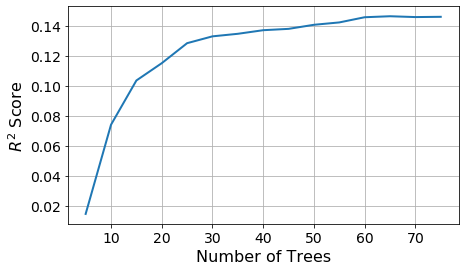

In [86]:
fig, ax = plt.subplots(1, 1, figsize=(7, 4))
ax.plot(score['n_tree'], score['mean_test_score'], linewidth = 2)
ax.set_title('', fontsize=20)
ax.grid(True)

ax.set_xlabel('Number of Trees', fontsize=16)
ax.set_ylabel(r'$R^2$' + ' Score', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

#plt.savefig('Tree_optimization_r2.png', dpi=600, bbox_inches = "tight")

In [69]:
sklearn.metrics.SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'accuracy', 'roc_auc', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'brier_score_loss', 'adjusted_rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_weighted'])

In [70]:
#Choose all predictors except target & IDcols
# predictors = [x for x in x_train]
param_test1 = {'n_estimators':range(5,76,5)}
treeplot = GridSearchCV(estimator = GradientBoostingRegressor(loss = 'lad',
                                                             learning_rate=0.08, 
                                                              min_samples_split=16,
                                                              min_samples_leaf=4,
                                                              max_depth=12,
                                                              max_features=5,
                                                              subsample=0.8,
                                                              random_state=42), 
param_grid = param_test1,scoring='r2', n_jobs=4,iid=False, cv=5)

treeplot.fit(x_train,y_train)

treeplot.cv_results_, treeplot.best_params_, treeplot.best_score_

({'mean_fit_time': array([ 0.04517179,  0.06029387,  0.08290458,  0.1274045 ,  0.1388422 ,
          0.16303158,  0.18342881,  0.22922692,  0.30737958,  0.35148802,
          0.49330344,  0.52150478,  0.48033881,  0.52767887,  0.34340014]),
  'std_fit_time': array([ 0.00131086,  0.00689201,  0.00449646,  0.00362313,  0.00560629,
          0.00565916,  0.00102976,  0.03007869,  0.01687803,  0.02455181,
          0.01465392,  0.02679275,  0.0116717 ,  0.06142526,  0.02766784]),
  'mean_score_time': array([ 0.00173664,  0.0009656 ,  0.00124459,  0.00130215,  0.00128317,
          0.00135179,  0.00135689,  0.00172386,  0.00193872,  0.00232139,
          0.0019917 ,  0.00213389,  0.00222874,  0.00203066,  0.00167551]),
  'std_score_time': array([  3.87965068e-04,   2.25514235e-05,   2.36183534e-04,
           2.70218598e-04,   1.70701975e-04,   1.81450756e-04,
           2.79595508e-04,   2.48771050e-04,   9.27999842e-05,
           3.86998306e-04,   3.29654582e-04,   2.84490272e-04,
      

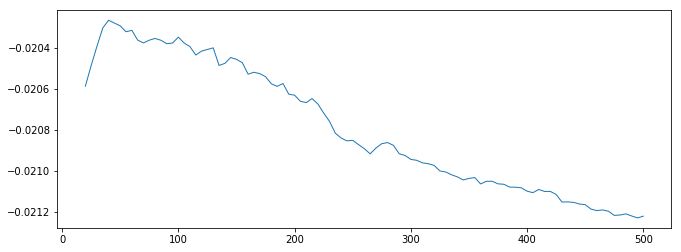

In [31]:
score = pd.DataFrame(treeplot.cv_results_)
score['n_tree'] = range(20,501,5)


fig, ax = plt.subplots(1, 1, figsize=(11, 4))
ax.plot(score['n_tree'], score['mean_test_score'], linewidth = 1)
# ax.set_title('Non-Tidal Component by FFT - Chesapeake Bay Bridge Tunnel', fontsize=20)
# #ax.set_xlabel('Date', fontsize=16)
# ax.set_ylabel('Water Elevation (m)', fontsize=16)
# plt.xticks(fontsize=14)
# plt.yticks(fontsize=14)

### Depth

In [33]:
param_test2 = {'max_depth':range(2,50,1)}
gsearch2 = GridSearchCV(estimator = GradientBoostingRegressor(loss = 'lad',
                                                              learning_rate=0.1, 
                                                              n_estimators=100, 
                                                              max_features='sqrt', 
                                                              subsample=0.8, 
                                                              random_state=42), 
param_grid = param_test2, n_jobs=4,iid=False, cv=5)

gsearch2.fit(x_train,y_train)

gsearch2.cv_results_, 
gsearch2.best_params_, gsearch2.best_score_

({'max_depth': 14}, 0.23956849825819013)

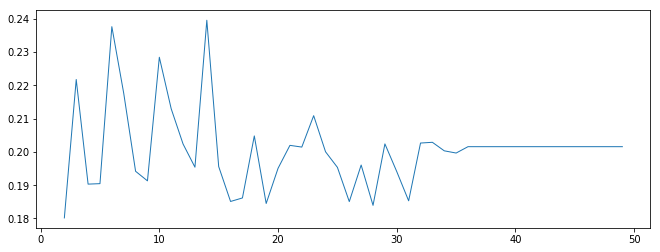

In [34]:
score = pd.DataFrame(gsearch2.cv_results_)
score['depth'] = range(2,50,1)


fig, ax = plt.subplots(1, 1, figsize=(11, 4))
ax.plot(score['depth'], score['mean_test_score'], linewidth = 1)
# ax.set_title('Non-Tidal Component by FFT - Chesapeake Bay Bridge Tunnel', fontsize=20)
# #ax.set_xlabel('Date', fontsize=16)
# ax.set_ylabel('Water Elevation (m)', fontsize=16)
# plt.xticks(fontsize=14)
# plt.yticks(fontsize=14)

# Optimization Results

In [64]:
# IDEAL1 (SCORE 70%/15%)

gbrt = GradientBoostingRegressor(loss = 'ls',
                                #alpha = .4,
                                learning_rate = 0.05,
                                n_estimators=175,
                                subsample = 0.78,
                                criterion = "friedman_mse",
                                min_samples_split = 2,
                                min_samples_leaf = 11,
                                random_state = 42,
                                max_depth = 6,
                                max_features = 1)
IDEAL1 = gbrt.fit(x_train, y_train)

print(IDEAL1.score(x_test, y_test))
print(IDEAL1.score(x_train, y_train))

0.198255017519
0.721742138841


In [65]:
#IDEAL2 (SCORE 80%/ 16%)

gbrt = GradientBoostingRegressor(loss = 'lad',
                                #alpha = .4,
                                learning_rate = 0.1,
                                n_estimators=500,
                                subsample = 0.9,
                                criterion = "friedman_mse",
                                min_samples_split = 2,
                                min_samples_leaf = 1,
                                random_state = 42,
                                max_depth = 5,
                                max_features = 'auto')
IDEAL2 = gbrt.fit(x_train, y_train)

print(IDEAL2.score(x_test, y_test))
print(IDEAL2.score(x_train, y_train))

0.243663257053
0.74767404271


In [66]:
# IDEAL3A (SCORE 57%/13%)

gbm_tuned_1 = GradientBoostingRegressor(loss = 'lad',
                                        learning_rate=0.05, 
                                        n_estimators=140,
                                        max_depth=12, 
                                        min_samples_split=19, 
                                        min_samples_leaf=9, 
                                        subsample=0.8, 
                                        random_state=42,
                                        max_features=3)
IDEAL3A = gbm_tuned_1.fit(x_train, y_train)

print(IDEAL3A.score(x_test, y_test))
print(IDEAL3A.score(x_train, y_train))

0.314986221928
0.578632509583


In [67]:
# IDEAL 3 (SCORE 82%/35%) -- R_IND_NOOUTLIER

gbm_tuned_1 = GradientBoostingRegressor(loss = 'lad',
                                        learning_rate=0.05, 
                                        n_estimators=500,
                                        max_depth=12, 
                                        min_samples_split=19,
                                        min_samples_leaf=3, 
                                        subsample=0.9, 
                                        random_state=42,
                                        max_features=3)
IDEAL3 = gbm_tuned_1.fit(x_train, y_train)

print(IDEAL3.score(x_test, y_test))
print(IDEAL3.score(x_train, y_train))

0.307185393879
0.78810178668


### R_IND

In [68]:
gbrt = GradientBoostingRegressor(loss = 'lad',
                                learning_rate=0.08,
                                max_depth = 12,
                                max_features=5,
                                min_samples_leaf= 4,
                                min_samples_split=16,
                                n_estimators=95,
                                subsample = 0.8,
                                random_state=42)

IDEAL4 = gbrt.fit(x_train, y_train)

print(IDEAL4.score(x_test, y_test))
print(IDEAL4.score(x_train, y_train))


0.363002750844
0.686059940664


In [69]:
# Results from optimization, switch up learning rate and see

gbrt = GradientBoostingRegressor(loss = 'lad',
                                learning_rate=0.08,
                                max_depth = 12,
                                max_features=4,
                                min_samples_leaf= 4,
                                min_samples_split=16,
                                n_estimators=108,
                                subsample = 0.74,
                                random_state=42)
                                         

IDEAL4A = gbrt.fit(x_train, y_train)

print(IDEAL4A.score(x_test, y_test))
print(IDEAL4A.score(x_train, y_train))

0.287613987229
0.645832966848


In [70]:
gbrt = GradientBoostingRegressor(loss = 'lad',
                                learning_rate=0.08,
                                max_depth = 12,
                                max_features=4,
                                min_samples_leaf= 2,
                                min_samples_split=10,
                                n_estimators=300,
                                subsample = 0.9,
                                random_state=42)
                                         

IDEAL5 = gbrt.fit(x_train, y_train)

print(IDEAL5.score(x_test, y_test))
print(IDEAL5.score(x_train, y_train))

0.282755856035
0.85795691478


In [71]:
# Best for R_InD_No0

gbrt = GradientBoostingRegressor(loss = 'lad',
                                learning_rate=0.08,
                                max_depth = 16,
                                max_features=2,
                                min_samples_leaf= 6,
                                min_samples_split=15,
                                n_estimators=103,
                                subsample = 0.8,
                                random_state=42)
                                         

IDEAL6 = gbrt.fit(x_train, y_train)

print(IDEAL6.score(x_test, y_test))
print(IDEAL6.score(x_train, y_train))

0.331411403988
0.63225400575


In [72]:
# Best for log R_InD_No0

gbrt = GradientBoostingRegressor(loss = 'lad',
                                learning_rate=0.08,
                                max_depth = 13,
                                max_features=4,
                                min_samples_leaf= 4,
                                min_samples_split=16,
                                n_estimators=110,
                                subsample = 0.9,
                                random_state=42)
                                         

IDEAL7 = gbrt.fit(x_train, y_train)

print(IDEAL7.score(x_test, y_test))
print(IDEAL7.score(x_train, y_train))

0.290692602974
0.710250880945


In [95]:
# tuned_model.fit(x_train, y_train)

### Evaluate

In [73]:
def predict(model, x_train, x_test):   
    pred_test = model.predict(x_test)
    pred_train = model.predict(x_train)
    
    return pred_train, pred_test

In [74]:
pred_train, pred_test = predict(IDEAL4, x_train, x_test)

In [75]:
def variance_score(model, x_train, y_train, x_test, y_test):
    r_train = model.score(x_train, y_train)
    r_test = model.score(x_test, y_test)
    
    return r_train, r_test

In [76]:
r_train, r_test = variance_score(IDEAL4, x_train, y_train, x_test, y_test)

In [77]:
r_test

0.36300275084449074

### If Log Target 

In [78]:
pred_train_inv_log = np.exp(pred_train)
pred_test_inv_log = np.exp(pred_test)
y_train_inv_log = np.exp(y_train)
y_test_inv_log = np.exp(y_test)

In [79]:
def evaluate_regression(pred_train, pred_test, y_train, y_test):
    r_train = r2_score(y_train, pred_train)
    print('The training r-squared score is {}'.format(r_train))
    r_test = r2_score(y_test, pred_test)
    print('The testing r-squared score is {}'.format(r_test))
    meanabserrors_train = np.mean(abs(pred_train - y_train))
    print('The training mean absolute error is {}'.format(meanabserrors_train))
    meanabserrors_test = np.mean(abs(pred_test - y_test))
    print('The testing mean absolute error is {}'.format(meanabserrors_test))
    rmse = math.sqrt(mean_squared_error(y_test, pred_test))
    print('The root mean square error is {}'.format(rmse))
    mse = mean_squared_error(y_test, pred_test)
    print('The mean square error is {}'.format(mse))
    errors = pred_test - y_test
    meanerror = np.mean(errors)
    print('The mean error is {}'.format(meanerror))
    return errors

In [80]:
# EXAMPLE
errors = evaluate_regression(pred_train, pred_test, y_train, y_test)

The training r-squared score is 0.6860599406635264
The testing r-squared score is 0.36300275084449074
The training mean absolute error is 0.00759598403042715
The testing mean absolute error is 0.017600747353697887
The root mean square error is 0.025279337913512546
The mean square error is 0.0006390449253455529
The mean error is -0.002123607972865393


In [81]:
#errors

In [91]:
def analyze_errors(errors):
    error_range =  max(errors) - min(errors)
    print('The error range is {}'.format(error_range))
    error_max = max(errors)
    print('The error max is {}'.format(error_max))
    error_min = min(errors)
    print('The error min is {}'.format(error_min))

In [92]:
# EXAMPLE
analyze_errors(errors)

The error range is 0.1856499781376471
The error max is 0.04745514904665086
The error min is -0.13819482909099626


In [93]:
def plot_errors(errors):
    plt.hist(errors, 30, histtype='bar', ec='white', color='maroon')
    plt.xlabel('Error')
    plt.ylabel('Count')
    plt.title('Histogram of Model Error')
    plt.grid(True)
    plt.show()

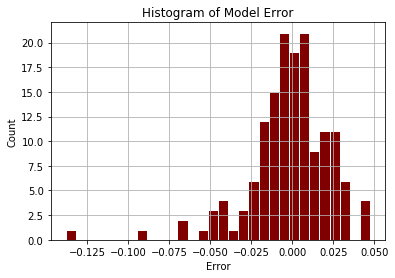

In [94]:
# EXAMPLE
plot_errors(errors)

In [95]:
def plot_predictions(y_test, pred, Title):
    df_predictions = pd.DataFrame(y_test)
    df_predictions['Pred'] = pred
    X = df_predictions.iloc[:, 0].values.reshape(-1, 1)
    Y = df_predictions.iloc[:, 1].values.reshape(-1, 1)
    fig, ax = plt.subplots()
    
    ax.scatter(X, Y, color='maroon', label = Title)
    plt.legend(fontsize=15)
    
    line = mlines.Line2D([0, 1], [0, 1], color='orange')
    transform = ax.transAxes
    line.set_transform(transform)
    ax.add_line(line)
    
    ax.set_xlabel(ax.get_xlabel(), fontsize = 18)
    ax.set_ylabel(ax.get_ylabel(), fontsize = 18)
    ax.tick_params(axis='both', which='major', labelsize=15)
    plt.grid(True)
    plt.xlabel("True Damage Index")
    plt.ylabel("Predicted Damage Index")
    plt.xlim(0,0.4)
    plt.ylim(0,0.4)
    #plt.title('Model Evaluation -' +  Title, fontsize = 20)
    #plt.savefig('gb_no0_train.png', dpi=600, bbox_inches = "tight")
    plt.show()

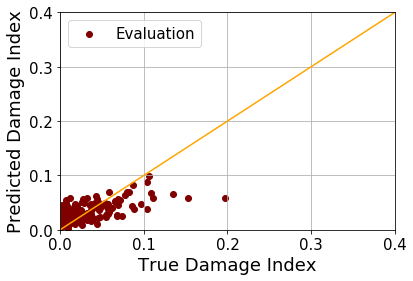

In [96]:
# EXAMPLE
plt.rcParams["figure.figsize"] = (6,4)
Title = 'Evaluation'
plot_predictions(y_test, pred_test, Title)

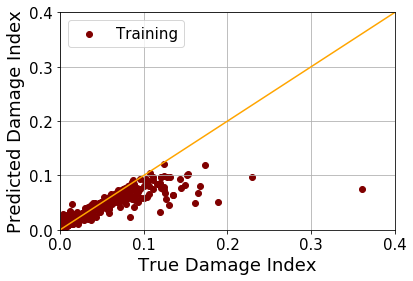

In [97]:
Title = 'Training'
plot_predictions(y_train, pred_train, Title)

In [98]:
def plot_joint_predictions(y_train, pred_train, y_test, pred_test, Title):
    df_predictions_test = pd.DataFrame(y_test)
    df_predictions_test['Pred'] = pred_test
    df_predictions_train = pd.DataFrame(y_train)
    df_predictions_train['Pred'] = pred_train   
    X1 = df_predictions_test.iloc[:, 0].values.reshape(-1, 1)
    Y1 = df_predictions_test.iloc[:, 1].values.reshape(-1, 1)
    X2 = df_predictions_train.iloc[:, 0].values.reshape(-1, 1)
    Y2 = df_predictions_train.iloc[:, 1].values.reshape(-1, 1)
    
    fig, ax = plt.subplots()
    ax.scatter(X2, Y2, color='maroon', label='Training Predictions')
    ax.scatter(X1, Y1, color='orange', label='Testing Predictions')
    
    line = mlines.Line2D([0, 1], [0, 1], color='grey')
    transform = ax.transAxes
    line.set_transform(transform)
    ax.add_line(line)
    ax.set_xlabel(ax.get_xlabel(), fontsize = 18)
    ax.set_ylabel(ax.get_ylabel(), fontsize = 18)
    ax.tick_params(axis='both', which='major', labelsize=15)
    plt.grid(True)
    plt.xlabel("Damage Index")
    plt.ylabel("Precited Damage Index")
    plt.xlim(0,0.4)
    plt.ylim(0,0.4)
    plt.title('Model Evaluation -' +  Title, fontsize = 20)
    plt.legend(loc='upper left')
    #plt.savefig('test_eval.png', dpi=600, bbox_inches = "tight")
    plt.show()


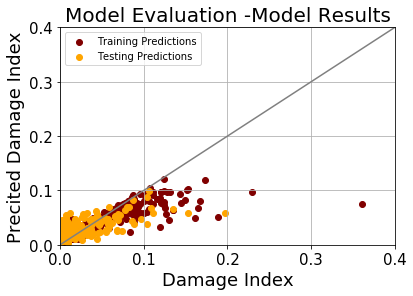

In [99]:
Title = 'Model Results'
plot_joint_predictions(y_train, pred_train, y_test, pred_test, Title)

In [100]:
def join_predictions(y_train, pred_train, y_test, pred_test, Title):
    df_predictions_test = pd.DataFrame(y_test)
    df_predictions_test['Pred'] = pred_test
    df_predictions_train = pd.DataFrame(y_train)
    df_predictions_train['Pred'] = pred_train   

    return df_predictions_test, df_predictions_train

In [101]:
df_predictions_test, df_predictions_train = join_predictions(y_train, pred_train, y_test, pred_test, Title)

In [102]:
df_predictions_train.describe()

,R_I_NO0,Pred
count,624.000000,624.000000
mean,0.036582,0.032357
std,0.036550,0.023205
min,0.000234,0.000929
25%,0.011958,0.014695
50%,0.027084,0.026970
75%,0.049020,0.046569
max,0.360825,0.120791


In [103]:
df_predictions_test.describe()

,R_I_NO0,Pred
count,151.000000,151.000000
mean,0.035957,0.033833
std,0.031779,0.017671
min,0.000820,0.003896
25%,0.012642,0.021026
50%,0.025959,0.030655
75%,0.047600,0.045485
max,0.197384,0.098551


In [104]:
# df_predictions_test.to_excel("/Users/lszczyrba/Documents/Research/Projects/PR_Housing/Data/sgb_no0_testpred.xlsx")
# df_predictions_train.to_excel("/Users/lszczyrba/Documents/Research/Projects/PR_Housing/Data/sgb_no0_trainpred.xlsx")

# Impurity importance

In [105]:
def calc_gini_importances(x_train, model):
    importances = model.feature_importances_
    importances_df = pd.DataFrame(importances, x_train.columns,
                                  columns=['Importance']).sort_values('Importance',
                                  ascending=False)
    importances_df.reset_index(inplace=True)
    importances_df.rename(columns={'index':'Feature'}, inplace=True)
    return importances_df


In [106]:
# indicate if reg_model or class_model
# EXAMPLE
df_gini_importances = calc_gini_importances(x_train, IDEAL4)

In [110]:
df_gini_importances

,Feature,Importance
0,STRVI_1,0.153550
1,CDC_Tot,0.149820
2,SEVI_1,0.135834
3,PeakGust,0.106752
4,SpecCom,0.106142
5,HurTrack,0.091876
6,PropSFHA,0.079182
7,AveLS,0.075985
8,AveDepth,0.063777
9,PropDG,0.037080


In [211]:
df_gini_importances['Labels'] = ['StrVI', 'CDCVuln', 'SeVI', 'PeakGust', 'PropSC', 'HurTrack', 'PropSFHA', 'AveLS', 'AveDepth', 'PropFA']

In [212]:
df_gini_importances

,Feature,Importance,Labels
0,STRVI_1,0.153550,StrVI
1,CDC_Tot,0.149820,CDCVuln
2,SEVI_1,0.135834,SeVI
3,PeakGust,0.106752,PeakGust
4,SpecCom,0.106142,PropSC
5,HurTrack,0.091876,HurTrack
6,PropSFHA,0.079182,PropSFHA
7,AveLS,0.075985,AveLS
8,AveDepth,0.063777,AveDepth
9,PropDG,0.037080,PropFA


In [221]:
def plot_importance(df_gini_importances):
    df_gini_importances.sort_values('Importance', ascending=False).plot.bar('Labels',
                                                                            'Importance', 
                                                                            color='maroon', 
                                                                            legend = False)
    plt.title("", fontsize = 25)
    plt.ylabel('Mean Decrease in MSE', fontsize = 16)
    plt.xlabel('')
    plt.xticks(fontsize = 16, rotation = 45, ha='right')
    plt.yticks(fontsize = 14)
    plt.savefig('MSE_gb_no0.png', dpi=600, bbox_inches = "tight")
    


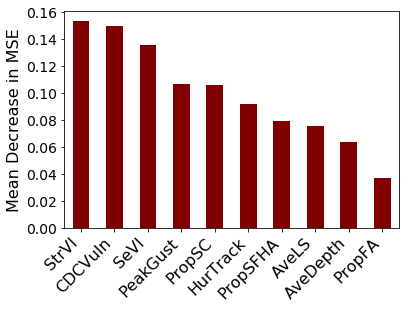

In [222]:
# EXAMPLE
# these values are Normalized Average Decrease In Total MSE
plot_importance(df_gini_importances)

# Permutation Importance

In [113]:
x_train.columns

Index(['PropSFHA', 'AveDepth', 'PropDG', 'AveLS', 'HurTrack', 'PeakGust',
       'SpecCom', 'STRVI_1', 'SEVI_1', 'CDC_Tot'],
      dtype='object')

In [120]:
IDEAL4.score(x_train,y_train)

0.68605994066352638

In [174]:
def calc_permutation_imp(model,x,y, features):
    baseline = model.score(x,y)
    imp = []
    for col in x.columns:
        save = x[col].copy()
        x[col]=np.random.permutation(x[col])
        m = model.score(x,y)
        x[col] = save
        imp.append(((baseline - m)/baseline)*100)
        
    Results = np.array(imp)
    Results = pd.DataFrame(Results)
    Results['Feature'] = features
    Results.rename(columns = {0:'Importance'}, inplace=True)
    
    return Results

In [175]:
features = ['PropSFHA', 'AveDepth', 'PropDG', 'AveLS', 'HurTrack',
       'PeakGust', 'SpecCom', 'STRVI_1', 'SEVI_1', 'CDC_Tot'] 
df_perm_imp = calc_permutation_imp(IDEAL4,x_train,y_train, features)

In [176]:
df_perm_imp.Importance.sum()

170.0223088642804

In [216]:
df_perm_imp

,Importance,Feature
0,8.634209,PropSFHA
1,11.031550,AveDepth
2,3.332507,PropDG
3,11.233267,AveLS
4,16.355693,HurTrack
5,20.220736,PeakGust
6,26.740190,SpecCom
7,28.666111,STRVI_1
8,25.630147,SEVI_1
9,18.177899,CDC_Tot


In [217]:
df_perm_imp['Labels'] = ['PropSFHA', 'AveDepth', 'PropFA', 'AveLS', 'HurTrack', 'PeakGust', 'PropSC', 'StrVI', 'SeVI', 'CDCVuln']

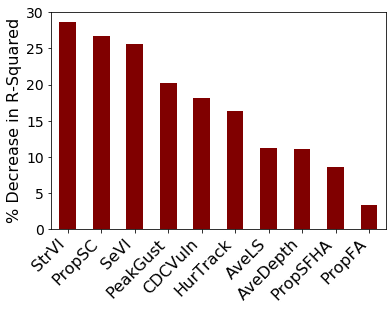

In [220]:
df_perm_imp.sort_values('Importance', ascending=False).plot.bar('Labels',
                                                                            'Importance', 
                                                                            color='maroon', 
                                                                            legend = False)
plt.title("", fontsize = 25)
plt.ylabel('% Decrease in R-Squared', fontsize = 16)
plt.xlabel('')
plt.xticks(fontsize = 16, rotation = 45, ha='right')
plt.yticks(fontsize = 14)
plt.savefig('I_Perm_gb_no0.png', dpi=600, bbox_inches = "tight")

In [234]:
# ## Y LABLEL SHOULD BE Percent DECREASE IN R^2
# plot_importance(df_perm_imp)

In [125]:
# def calc_permutation_imp(model,x,y,features):
#     baseline = model.score(x,y)
#     imp = []
#     features = features
#     for col in features:
#         save = x.copy()
#         x[col]=np.random.permutation(x[col])
#         m = model.score(x,y)
#         x[col] = save
#         imp.append(baseline - m)
#     Results = np.array(imp)
#     Results = pd.DataFrame(Results)
#     Results['Feature'] = features
#     Results.rename(columns = {0:'Importance'}, inplace=True)
#     return Results

In [126]:
# features = ['PropSFHA', 'AveDepth', 'PropDG', 'AveLS', 'HurTrack', 'PeakGust',
#        'SpecCom', 'STRVI_1', 'SEVI_1', 'CDC_Tot'] 
# df_perm_imp = calc_permutation_imp(IDEAL4,x_train,y_train,features)

In [127]:
# plot_importance(df_perm_imp)

### Group Permutation Importance

In [223]:
x_train.columns

Index(['PropSFHA', 'AveDepth', 'PropDG', 'AveLS', 'HurTrack', 'PeakGust',
       'SpecCom', 'STRVI_1', 'SEVI_1', 'CDC_Tot'],
      dtype='object')

In [224]:
features = [['PeakGust', 'HurTrack'],
           ['STRVI_1', 'SpecCom', 'SEVI_1', 'CDC_Tot'],
           ['AveDepth', 'PropDG', 'PropSFHA'],
           ['AveLS']]

In [225]:
I = importances(IDEAL4, x_train,y_train, features=features)

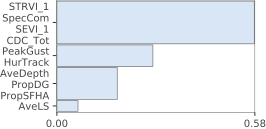

In [226]:
plot_importances(I)

In [227]:
I.reset_index(inplace=True)
I.drop(['Feature'], axis=1)
I['Feature'] = ['Vulnerability', 'Wind', 'Flood', 'Landslide']

In [228]:
I

,Feature,Importance
0,Vulnerability,0.581847
1,Wind,0.283174
2,Flood,0.177791
3,Landslide,0.062193


In [229]:
base_score = IDEAL4.score(x_train, y_train)

In [230]:
I['basescore'] = base_score

In [231]:
I

,Feature,Importance,basescore
0,Vulnerability,0.581847,0.68606
1,Wind,0.283174,0.68606
2,Flood,0.177791,0.68606
3,Landslide,0.062193,0.68606


In [232]:
I['Perc_Dec'] = ((I['Importance']) / I['basescore']) * 100

In [233]:
I

,Feature,Importance,basescore,Perc_Dec
0,Vulnerability,0.581847,0.68606,84.809972
1,Wind,0.283174,0.68606,41.275412
2,Flood,0.177791,0.68606,25.914801
3,Landslide,0.062193,0.68606,9.065227


In [208]:
I.Importance.sum()

1.0959223828767815

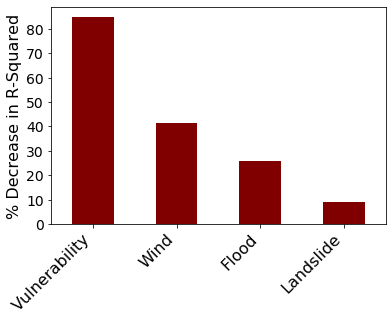

In [236]:
I.sort_values('Perc_Dec', ascending=False).plot.bar('Feature',
                                                                            'Perc_Dec', 
                                                                            color='maroon', 
                                                                            legend = False)
plt.title("", fontsize = 25)
plt.ylabel('% Decrease in R-Squared', fontsize = 16)
plt.xlabel('')
plt.xticks(fontsize = 16, rotation = 45, ha='right')
plt.yticks(fontsize = 14)
plt.savefig('G_Perm_gb_no0.png', dpi=600, bbox_inches = "tight")

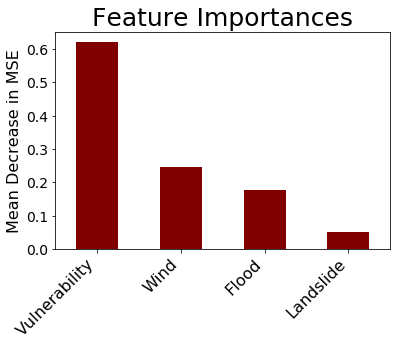

In [209]:
plot_importance(I)

# Partial Dependence

In [67]:
x_train.columns

Index(['PropSFHA', 'AveDepth', 'PropDG', 'AveLS', 'HurTrack', 'PeakGust',
       'SpecCom', 'STRVI_1', 'SEVI_1', 'CDC_Tot'],
      dtype='object')

In [70]:
def plot_part_depend(model, x_train, feature_list, feature_names):
    with plt.rc_context({'legend.fontsize': 'large',
              'figure.figsize': (20, 40),
             'axes.labelsize': 'large',
             'axes.titlesize':'x-large',
             'xtick.labelsize':'large',
             'ytick.labelsize':'large'}):
        #plt.subplots(nrows=3,ncols=3, sharey=True)
        plot_partial_dependence(model, 
                                x_train, 
                                feature_list, 
                                feature_names = feature_names, 
                                grid_resolution=10, 
                                n_cols=2,
                                method='brute'
                               ) 
        #plt.savefig('partialdependence.png', dpi=400, bbox_inches = "tight")


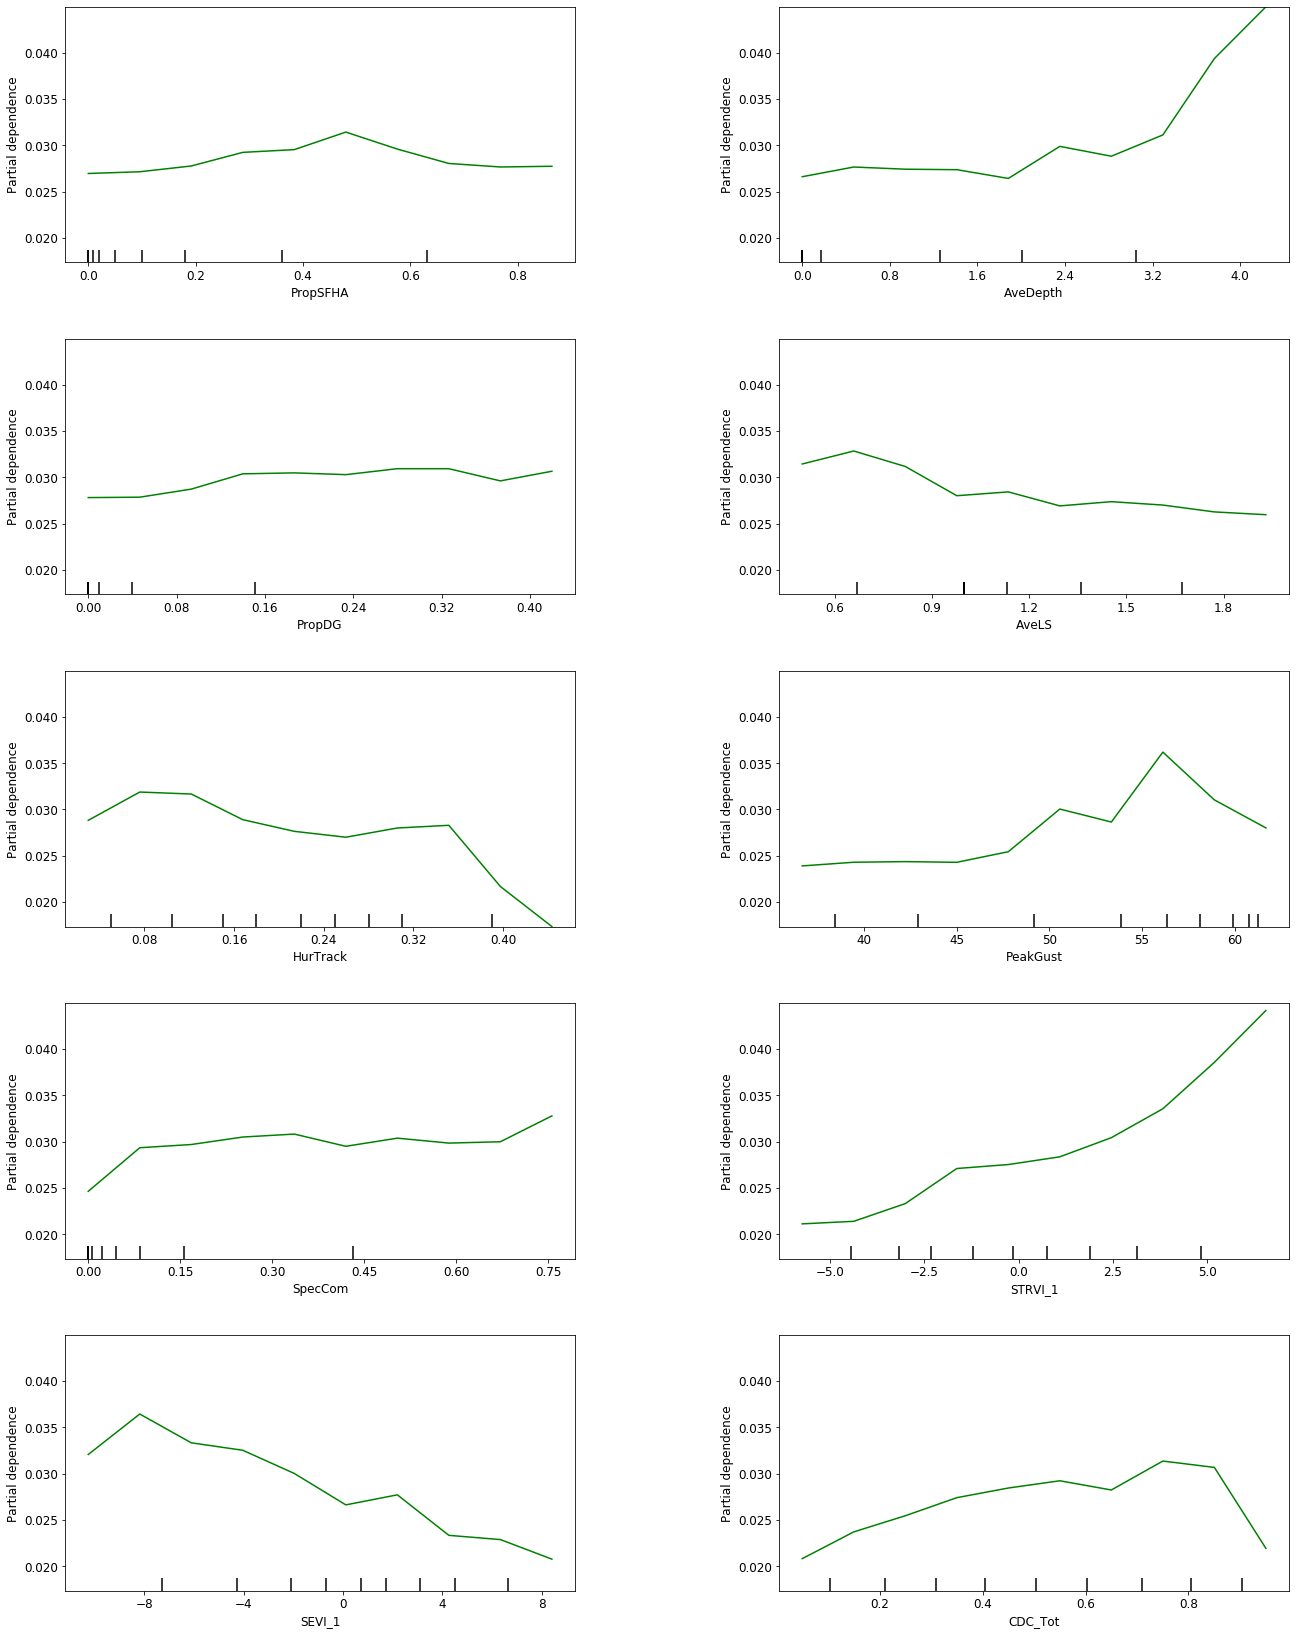

In [72]:
#EXAMPLE
feature_list=[0,1,2,3,4,5,6,7,8,9]
feature_names=['PropSFHA', 'AveDepth', 'PropDG', 'AveLS', 'HurTrack',
       'PeakGust', 'SpecCom', 'STRVI_1', 'SEVI_1', 'CDC_Tot']
plot_part_depend(IDEAL4, x_train, feature_list, feature_names)

In [73]:
# plt.rcParams["figure.figsize"] = (10,10)
# params = {'legend.fontsize': 'x-large',
#           'figure.figsize': (10, 10),
#          'axes.labelsize': 'x-large',
#          'axes.titlesize':'x-large',
#          'xtick.labelsize':'large',
#          'ytick.labelsize':'large'}
# plt.rcParams.update(params)


# #plt.subplots(nrows=3,ncols=3, sharey=True)
# fig = plot_partial_dependence(IDEAL1, 
#                         x_train, 
#                         [0,1,2,3,4,5,6,7,8,9,10,11,12,13], 
#                         feature_names =['PropSFHA', 'AveDepth', 'PropDG', 'MaxDepth', 'AveLS', 'HurTrack',
#                            'PeakGust', 'MaxSusta', 'SpecCom', 'STRVI_1', 'SEVI_1', 'STR_SEVI_1',
#                            'SOVI_1', 'CDC_Tot'], 
#                         grid_resolution=10, 
#                         #n_cols=2
#                        ) 

# plt.tight_layout(h_pad=3,w_pad=1)

# plt.savefig('partialdependence.png', dpi=400, bbox_inches = "tight")



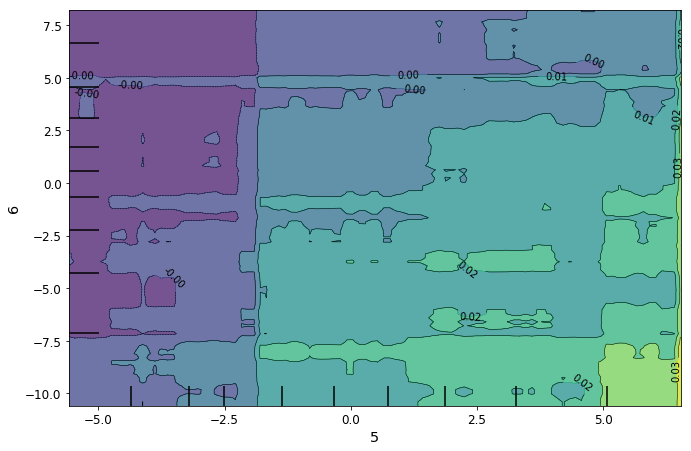

In [90]:
fig = plot_partial_dependence(IDEAL2, x_train, [(5,6)]) 

In [29]:
from pycebox.ice import ice, ice_plot

In [31]:
forty_ice_df = ice(data=x_train, column='HurTrack', 
                   predict=IDEAL2.predict)

In [33]:
cmap2 = plt.get_cmap('OrRd')

In [44]:
wt_vals = forty_ice_df.columns.get_level_values('PeakGust').values
sm = plt.cm.ScalarMappable(cmap=cmap2, 
                           norm=plt.Normalize(vmin=wt_vals.min(), 
                                              vmax=wt_vals.max()))
sm._A = []

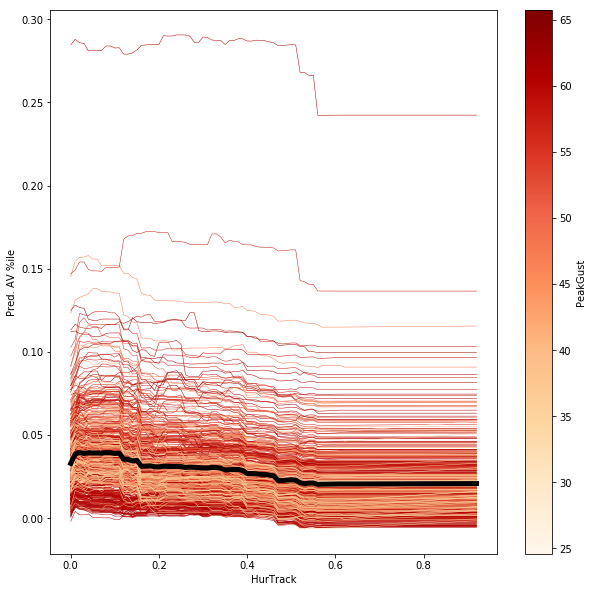

In [47]:
ice_plot(forty_ice_df, linewidth=.5, color_by='PeakGust', cmap=cmap2, plot_pdp=True, 
         pdp_kwargs={'c': 'k', 'linewidth': 5})
plt.colorbar(sm, label='PeakGust')
plt.ylabel('Pred. AV %ile')
plt.xlabel('HurTrack');

In [153]:
def calc_permutation_importance(criterion, model, df_x, y):
    features = df_x.columns.values
    X = df_x.as_matrix()
    Y = y.as_matrix()
    scores = defaultdict(list)
    rf = model
    for train_idx, test_idx in ShuffleSplit(len(X), 100, .3, random_state=42): #number of splits, absolute number of test samples, proportion of data in train split
        X_train, X_test = X[train_idx], X[test_idx] #Random permutation cross-validator, Yields indices to split data into training and test sets.
        Y_train, Y_test = Y[train_idx], Y[test_idx]
        r = rf.fit(X_train, Y_train)
        acc = criterion(Y_test, rf.predict(X_test))
        for i in range(X.shape[1]): #The shape attribute for numpy arrays returns the dimensions of the array. If Y has n rows and m columns, then Y.shape is (n,m). So Y.shape[0] is n.
            X_t = X_test.copy()
            np.random.seed(42)
            np.random.shuffle(X_t[:, i]) #rearranging randomly
            shuff_acc = criterion(Y_test, rf.predict(X_t)) 
            scores[features[i]].append((acc-shuff_acc)/acc) #change in importance, actual - shuffled/actual, this is percent error        
    mda_features = [f for f in scores.keys()]
    mda_importance = [(np.mean(score)) for score in scores.values()] #average over all the shuffled permutations
    mda_indices = np.argsort(mda_importance)
    return mda_features, mda_importance, mda_indices

In [154]:
#EXAMPLE
#criterion can be r2_score or mean_squared_error
#should be MSE i think

criterion = r2_score
mda_features, mda_importance, mda_indices = calc_permutation_importance(criterion, IDEAL4, x_train, y_train)

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


TypeError: 'ShuffleSplit' object is not iterable

In [104]:
# def permutation_importance_plot(mda_features, mda_importance):
#     df_perm_FI = pd.DataFrame({'Feature':mda_features, 'Importance':[abs(number) for number in mda_importance]})
#     df_perm_FI.sort_values('Importance', ascending=False).plot.bar('Feature',
#                                                                    'Importance', 
#                                                                     color='maroon', 
#                                                                     legend = False)
#     plt.title("Feature Importances", fontsize = 30)
#     plt.ylabel('Importance')
#     plt.xlabel('')
#     plt.xticks(fontsize = 12, rotation = 45, ha='right')
#     plt.savefig('permutimportance.png', dpi=600, bbox_inches = "tight")

In [105]:
# # EXAMPLE
# permutation_importance_plot(mda_features, mda_importance)

In [146]:
def permutation_importances(rf, X_train, y_train, metric):
    baseline = metric(rf, X_train, y_train)
    imp = []
    for col in X_train.columns:
        save = X_train[col].copy()
        X_train[col] = np.random.permutation(X_train[col])
        m = metric(rf, X_train, y_train)
        X_train[col] = save
        imp.append(baseline - m)
    return np.array(imp)

In [143]:
hi = GradientBoostingRegressor(loss = 'lad',
                                learning_rate=0.08,
                                max_depth = 12,
                                max_features=5,
                                min_samples_leaf= 4,
                                min_samples_split=16,
                                n_estimators=95,
                                subsample = 0.8)

In [144]:
OPT4 = hi.fit(x_train, y_train)

In [145]:
imp = permutation_importances(OPT4, x_train, y_train, oob_regression_r2_score)


AttributeError: 'numpy.ndarray' object has no attribute 'random_state'

In [ ]:
impcopy = imp.copy()

In [87]:
def perm_imp_plot(importances):
    importances.reset_index(inplace=True)
    importances.sort_values('Importance', ascending=False).plot.bar('Feature',
                                                                            'Importance', 
                                                                            color='maroon', 
                                                                            legend = False)
    plt.title("Feature Importances", fontsize = 25)
    plt.ylabel('Importance', fontsize = 16)
    plt.xlabel('')
    plt.xticks(fontsize = 16, rotation = 45, ha='right')
    plt.yticks(fontsize = 14)
#     plt.savefig('giniimportance.png', dpi=600, bbox_inches = "tight")

AttributeError: 'numpy.ndarray' object has no attribute 'random_state'

In [ ]:
perm_imp_plot(imp)